# Feature Selection for Uplift Modeling
  
    
This notebook includes two sections:  
- **Feature selection**: demonstrate how to use Filter methods to select the most important numeric features
- **Performance evaluation**: evaluate the AUUC performance with top features dataset
  
*(Paper reference: [Zhao, Zhenyu, et al. "Feature Selection Methods for Uplift Modeling." arXiv preprint arXiv:2005.03447 (2020).](https://arxiv.org/abs/2005.03447))*

In [1]:
import numpy as np
import pandas as pd

In [2]:
from causalml.dataset import make_uplift_classification

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
from causalml.feature_selection.filters import FilterSelect

In [4]:
from causalml.inference.tree import UpliftRandomForestClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.metrics import plot_gain, auuc_score, get_cumgain, get_cumlift

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [6]:
import logging

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

### Generate dataset

Generate synthetic data using the built-in function.

In [7]:
# define parameters for simulation

y_name = 'conversion'
treatment_group_keys = ['control', 'treatment1']
n = 100000
n_classification_features = 50
n_classification_informative = 10
n_classification_repeated = 0
n_uplift_increase_dict = {'treatment1': 8}
n_uplift_decrease_dict = {'treatment1': 4}
delta_uplift_increase_dict = {'treatment1': 0.1}
delta_uplift_decrease_dict = {'treatment1': -0.1}

random_seed = 20200808

In [8]:
df, X_names = make_uplift_classification(
    treatment_name=treatment_group_keys,
    y_name=y_name,
    n_samples=n,
    n_classification_features=n_classification_features,
    n_classification_informative=n_classification_informative,
    n_classification_repeated=n_classification_repeated,
    n_uplift_increase_dict=n_uplift_increase_dict,
    n_uplift_decrease_dict=n_uplift_decrease_dict,
    delta_uplift_increase_dict = delta_uplift_increase_dict, 
    delta_uplift_decrease_dict = delta_uplift_decrease_dict,
    random_seed=random_seed
)

In [9]:
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_informative,x7_informative,x8_informative,x9_informative,...,x56_uplift_increase,x57_uplift_increase,x58_uplift_increase,x59_increase_mix,x60_uplift_decrease,x61_uplift_decrease,x62_uplift_decrease,x63_uplift_decrease,conversion,treatment_effect
0,control,0.653960,-0.217603,1.856916,-0.075662,0.080971,-0.338374,-1.011470,0.528000,0.115418,...,1.533832,-2.183001,1.839608,0.755302,1.835047,-0.458431,-1.927525,2.765331,0,0
1,control,3.439658,0.477855,-0.377658,-1.317121,0.861815,-0.393180,0.503727,2.323846,1.229948,...,-1.192333,-1.581815,2.423700,2.396904,0.296043,-1.961940,-1.444725,1.469213,1,0
2,treatment1,0.130907,-0.333536,0.474847,-0.352067,-0.024502,1.437105,0.566178,-0.232508,0.866236,...,-0.301982,-0.933816,0.475274,1.540994,0.698066,0.545091,-0.084405,-2.337347,1,0
3,treatment1,-2.156683,1.120198,0.174293,-1.741426,0.488993,0.638340,-0.721928,1.802134,1.097178,...,-2.129098,-1.183581,0.000318,1.105735,-0.629281,-0.737041,-1.525081,1.416042,0,0
4,control,-2.708572,-0.799698,-2.199595,0.574077,0.083142,-0.389140,1.492101,1.725202,1.194315,...,1.582041,-1.176077,1.686322,0.480035,1.780710,0.862094,0.128872,-2.851344,0,0


In [10]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.499050,100000
treatment1,0.599680,100000
All,0.549365,200000


In [11]:
X_names

['x1_informative',
 'x2_informative',
 'x3_informative',
 'x4_informative',
 'x5_informative',
 'x6_informative',
 'x7_informative',
 'x8_informative',
 'x9_informative',
 'x10_informative',
 'x11_irrelevant',
 'x12_irrelevant',
 'x13_irrelevant',
 'x14_irrelevant',
 'x15_irrelevant',
 'x16_irrelevant',
 'x17_irrelevant',
 'x18_irrelevant',
 'x19_irrelevant',
 'x20_irrelevant',
 'x21_irrelevant',
 'x22_irrelevant',
 'x23_irrelevant',
 'x24_irrelevant',
 'x25_irrelevant',
 'x26_irrelevant',
 'x27_irrelevant',
 'x28_irrelevant',
 'x29_irrelevant',
 'x30_irrelevant',
 'x31_irrelevant',
 'x32_irrelevant',
 'x33_irrelevant',
 'x34_irrelevant',
 'x35_irrelevant',
 'x36_irrelevant',
 'x37_irrelevant',
 'x38_irrelevant',
 'x39_irrelevant',
 'x40_irrelevant',
 'x41_irrelevant',
 'x42_irrelevant',
 'x43_irrelevant',
 'x44_irrelevant',
 'x45_irrelevant',
 'x46_irrelevant',
 'x47_irrelevant',
 'x48_irrelevant',
 'x49_irrelevant',
 'x50_irrelevant',
 'x51_uplift_increase',
 'x52_uplift_increase',
 'x53_uplift_increase',
 'x54_uplift_increase',
 'x55_uplift_increase',
 'x56_uplift_increase',
 'x57_uplift_increase',
 'x58_uplift_increase',
 'x59_increase_mix',
 'x60_uplift_decrease',
 'x61_uplift_decrease',
 'x62_uplift_decrease',
 'x63_uplift_decrease']

## Feature selection with Filter methods

### method = F (F statistics)

In [12]:
filter_f = FilterSelect() 

In [13]:
method = 'F'
f_imp = filter_f.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1')
print(f_imp)

      method              feature  rank        score        p_value  \
0   F filter  x57_uplift_increase   1.0  1973.380496   0.000000e+00   
0   F filter  x51_uplift_increase   2.0  1885.342364   0.000000e+00   
0   F filter  x54_uplift_increase   3.0  1496.254091   0.000000e+00   
0   F filter  x58_uplift_increase   4.0  1269.167710  4.224019e-277   
0   F filter       x9_informative   5.0   677.066204  5.151887e-149   
0   F filter  x63_uplift_decrease   6.0     9.108409   2.544691e-03   
0   F filter  x61_uplift_decrease   7.0     5.978189   1.448472e-02   
0   F filter       x19_irrelevant   8.0     5.295584   2.138059e-02   
0   F filter       x46_irrelevant   9.0     5.237353   2.210792e-02   
0   F filter       x27_irrelevant  10.0     4.573196   3.247713e-02   
0   F filter       x11_irrelevant  11.0     4.297030   3.818027e-02   
0   F filter       x39_irrelevant  12.0     4.009421   4.524803e-02   
0   F filter       x42_irrelevant  13.0     3.788770   5.159896e-02   
0   F 

### method = LR (likelihood ratio test)

In [14]:
method = 'LR'
lr_imp = filter_f.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1')
print(lr_imp)

Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683142
  

Optimization terminated successfully.
         Current function value: 0.683140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683126
  

### method = KL (KL divergence)

In [15]:

method = 'KL'
kl_imp = filter_f.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1',
                      n_bins=10)
print(kl_imp)

       method              feature  rank     score p_value                misc
0   KL filter  x51_uplift_increase   1.0  0.026008    None  number_of_bins: 10
0   KL filter  x57_uplift_increase   2.0  0.023749    None  number_of_bins: 10
0   KL filter       x9_informative   3.0  0.020550    None  number_of_bins: 10
0   KL filter  x54_uplift_increase   4.0  0.018411    None  number_of_bins: 10
0   KL filter  x58_uplift_increase   5.0  0.014443    None  number_of_bins: 10
0   KL filter  x52_uplift_increase   6.0  0.002416    None  number_of_bins: 10
0   KL filter  x55_uplift_increase   7.0  0.000283    None  number_of_bins: 10
0   KL filter       x23_irrelevant   8.0  0.000221    None  number_of_bins: 10
0   KL filter     x59_increase_mix   9.0  0.000218    None  number_of_bins: 10
0   KL filter       x21_irrelevant  10.0  0.000206    None  number_of_bins: 10
0   KL filter       x15_irrelevant  11.0  0.000157    None  number_of_bins: 10
0   KL filter       x11_irrelevant  12.0  0.000155  

We found all these 3 filter methods were able to rank most of the **informative** and **uplift increase** features on the top.

## Performance evaluation  

Evaluate the AUUC (Area Under the Uplift Curve) score with several uplift models when using top features dataset 

In [16]:
# train test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

Using the utility function from [uplift_trees_with_synthetic_data.ipynb](https://github.com/uber/causalml/blob/master/examples/uplift_trees_with_synthetic_data.ipynb) example notebook to help us draw the plot and calculate the score

In [17]:
def plot_uplift(model, df, features, y_name='conversion', columns=None):
    """
    Plot the uplift curve for the trained model

    Parameters
    ----------
    model (uplift models): trained uplift model
    df (pd.Dataframe): DataFrame containing outcome, features, and experiment group
    features (list of string): feature names in the data set
    
    Returns
    ----------
    auuc_metrics (pd.DataFrame): a data frame containing treatment, outcome, and uplift score
    best_treatment (list of string): best treatment groups (or control) per uplift score
    """
    
    y_pred = model.predict(df[features].values)
    # Put the predictions to a DataFrame for a neater presentation
    
    if not columns:
        columns = model.classes_
    
    result = pd.DataFrame(y_pred,
                          columns=columns)
    
    # If all deltas are negative, assing to control; otherwise assign to the treatment
    # with the highest delta
    best_treatment = np.where((result < 0).all(axis=1),
                               'control',
                               result.idxmax(axis=1))
    
    #print(len([t for t in best_treatment if t == 'control']))
    
    # Create indicator variables for whether a unit happened to have the
    # recommended treatment or was in the control group
    actual_is_best = np.where(df['treatment_group_key'] == best_treatment, 1, 0)
    actual_is_control = np.where(df['treatment_group_key'] == 'control', 1, 0)

    synthetic = (actual_is_best == 1) | (actual_is_control == 1)
    synth = result[synthetic]    
    
    auuc_metrics = pd.DataFrame({
        'uplift_tree': synth.max(axis=1),
        y_name: df.loc[synthetic, 'conversion'].values,
        'is_treated': 1 - actual_is_control[synthetic]}
    )   
    
    plot_gain(auuc_metrics, outcome_col=y_name, treatment_col='is_treated')
    return auuc_metrics, best_treatment


In [18]:
def get_auuc_score(auuc_metrics_df, y_name='conversion'):
    """
    Print the AUUC (Area Under the Uplift Curve) score

    Parameters
    ----------
    auuc_metrics_df (pd.Dataframe): a data frame containing treatment, outcome, and uplift score
    y_name (string): name of the outcome variable
    
    Returns
    ----------
    cumgain (pd.DataFrame): a data frame containing random assigment and uplift model's cumulative gains
    """
    cumgain = get_cumgain(auuc_metrics_df,
                          outcome_col=y_name, 
                          treatment_col='is_treated',
                          normalize=True)
    print('AUUC: {}'.format(cumgain.sum() / cumgain.shape[0]))
    return cumgain

In [19]:
def model_train(model, df_train, df_test, features, y_name='conversion'):
    """
    Train a model and validate with testing set, 
    then plot the uplift curve and calculate the AUUC 
    """
    
    # fit training set
    model.fit(df_train[features].values,
              treatment=df_train['treatment_group_key'].values,
              y=df_train[y_name].values)

    # apply to testing set and calculate the uplift gain
    auuc_result, _ = plot_uplift(model, df_test, features, columns={'treatment1': 0})
    cumgain = get_auuc_score(auuc_result)
    return auuc_result, cumgain

### Uplift RandomForest Classfier

In [20]:
uplift_model = UpliftRandomForestClassifier(control_name='control', max_depth=8)

AUUC: uplift_tree    0.853529
Random         0.504316
dtype: float64


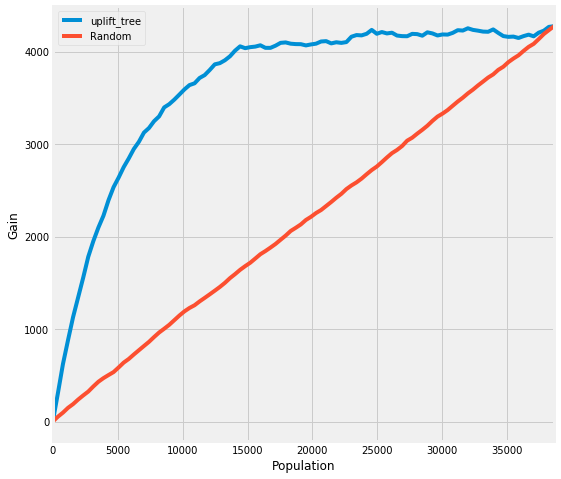

In [21]:
# using all the features
uplift_model.fit(df_train[X_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

auuc_result, _ = plot_uplift(uplift_model, df_test, X_names)
up_rf_gain = get_auuc_score(auuc_result)

### Select top N features based on KL filter

In [22]:
top_n = 10
top_10_features = kl_imp['feature'][:top_n]
print(top_10_features)

0    x51_uplift_increase
0    x57_uplift_increase
0         x9_informative
0    x54_uplift_increase
0    x58_uplift_increase
0    x52_uplift_increase
0    x55_uplift_increase
0         x23_irrelevant
0       x59_increase_mix
0         x21_irrelevant
Name: feature, dtype: object


In [23]:
top_n = 15
top_15_features = kl_imp['feature'][:top_n]
print(top_15_features)

0    x51_uplift_increase
0    x57_uplift_increase
0         x9_informative
0    x54_uplift_increase
0    x58_uplift_increase
0    x52_uplift_increase
0    x55_uplift_increase
0         x23_irrelevant
0       x59_increase_mix
0         x21_irrelevant
0         x15_irrelevant
0         x11_irrelevant
0         x46_irrelevant
0         x39_irrelevant
0    x53_uplift_increase
Name: feature, dtype: object


In [24]:
top_n = 20
top_20_features = kl_imp['feature'][:top_n]
print(top_20_features)

0    x51_uplift_increase
0    x57_uplift_increase
0         x9_informative
0    x54_uplift_increase
0    x58_uplift_increase
0    x52_uplift_increase
0    x55_uplift_increase
0         x23_irrelevant
0       x59_increase_mix
0         x21_irrelevant
0         x15_irrelevant
0         x11_irrelevant
0         x46_irrelevant
0         x39_irrelevant
0    x53_uplift_increase
0        x10_informative
0         x2_informative
0         x31_irrelevant
0         x19_irrelevant
0         x40_irrelevant
Name: feature, dtype: object


#### Using top N features to re-evaluate the Uplift model

AUUC: uplift_tree    0.849646
Random         0.487336
dtype: float64


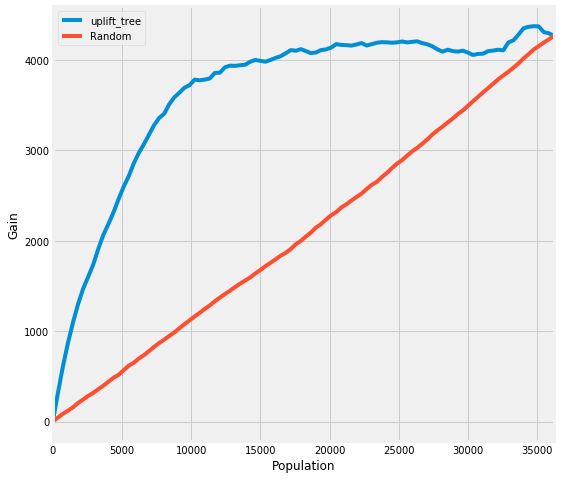

In [25]:
# using top 10 features for uplift_model
up_rf_res_t10, up_rf_gain_t10 = model_train(uplift_model, df_train, df_test, top_10_features)

AUUC: uplift_tree    0.910246
Random         0.507677
dtype: float64


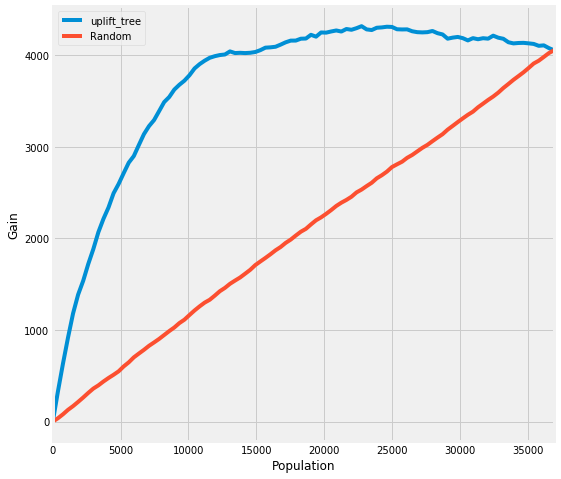

In [26]:
# using top 15 features for uplift_model

up_rf_res_t15, up_rf_gain_t15 = model_train(uplift_model, df_train, df_test, top_15_features)

AUUC: uplift_tree    0.859891
Random         0.503943
dtype: float64


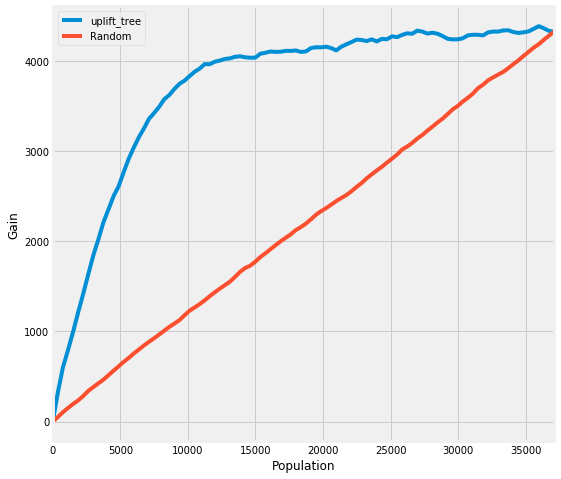

In [27]:
# using top 20 features for uplift_model
up_rf_res_t20, _ = model_train(uplift_model, df_train, df_test, top_20_features)

### R Learner as base and feed in Random Forest Regressor

In [28]:
r_rf_learner = BaseRRegressor(
    RandomForestRegressor(
        n_estimators = 100,
        max_depth = 8,
        min_samples_leaf = 100
    ), 
control_name='control') 

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


AUUC: uplift_tree    0.710244
Random         0.496015
dtype: float64


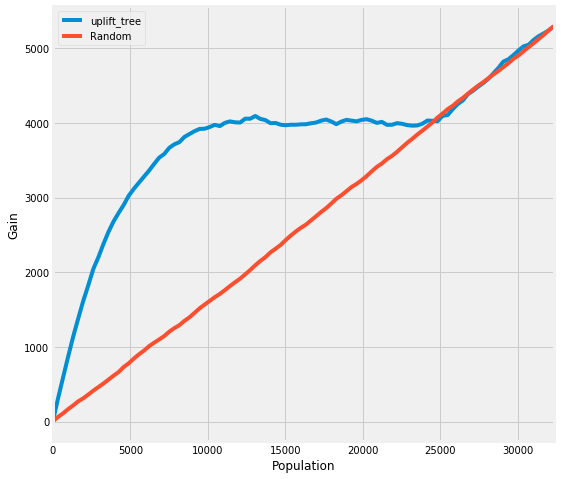

In [29]:
# all features
r_rf_res, _ = model_train(r_rf_learner, df_train, df_test, X_names)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


AUUC: uplift_tree    0.834346
Random         0.500477
dtype: float64


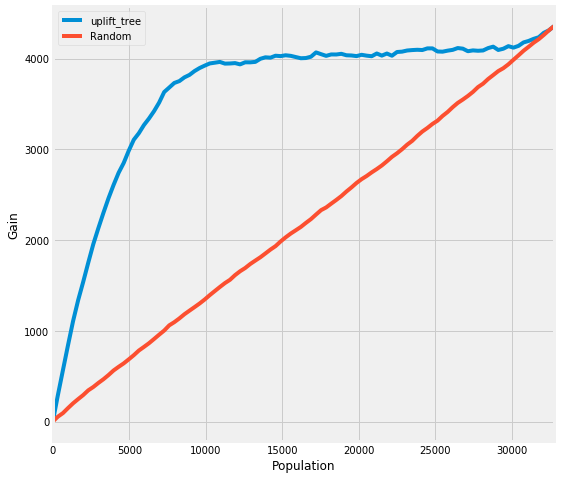

In [30]:
# top 10 features
r_rf_res_t10, _ = model_train(r_rf_learner, df_train, df_test, top_10_features)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


AUUC: uplift_tree    0.716229
Random         0.503565
dtype: float64


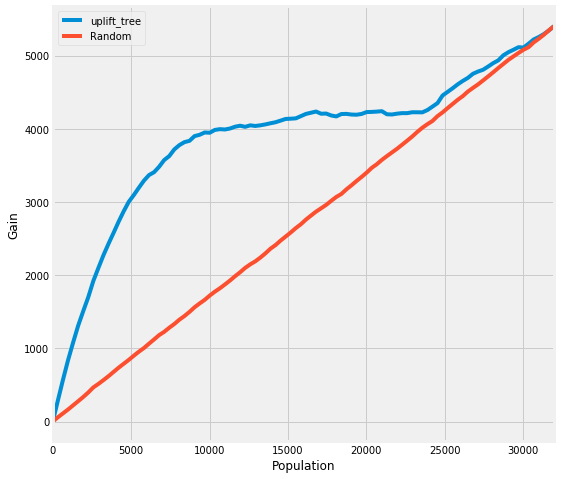

In [31]:
# top 15 features
r_rf_res_t15, _ = model_train(r_rf_learner, df_train, df_test, top_15_features)

### S Learner as base and feed in Random Forest Regressor

In [32]:
slearner_rf = BaseSRegressor(
    RandomForestRegressor(
        n_estimators = 100,
        max_depth = 8,
        min_samples_leaf = 100
    ), 
    control_name='control')

AUUC: uplift_tree    0.837666
Random         0.498670
dtype: float64


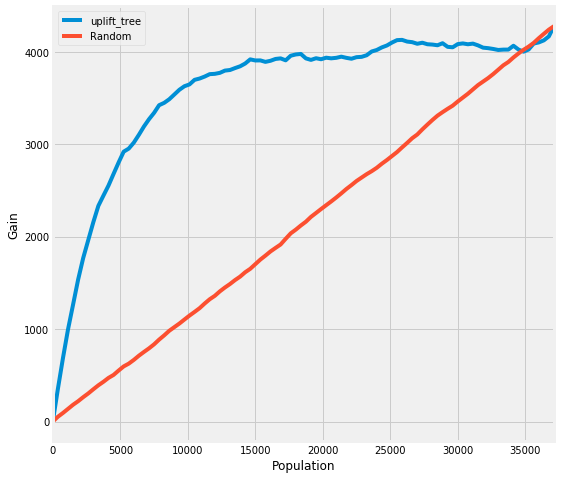

In [33]:
# using all features
s_rf_res, _ = model_train(slearner_rf, df_train, df_test, X_names)

AUUC: uplift_tree    0.872580
Random         0.498674
dtype: float64


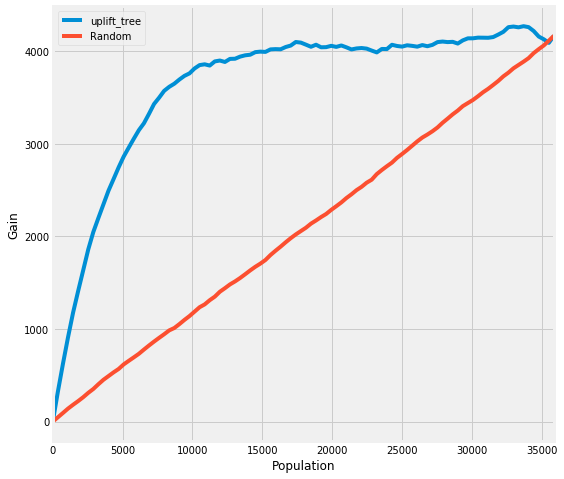

In [34]:
# using top 15 features 
s_rf_res_t15, _ = model_train(slearner_rf, df_train, df_test, top_15_features)

AUUC: uplift_tree    0.858258
Random         0.502549
dtype: float64


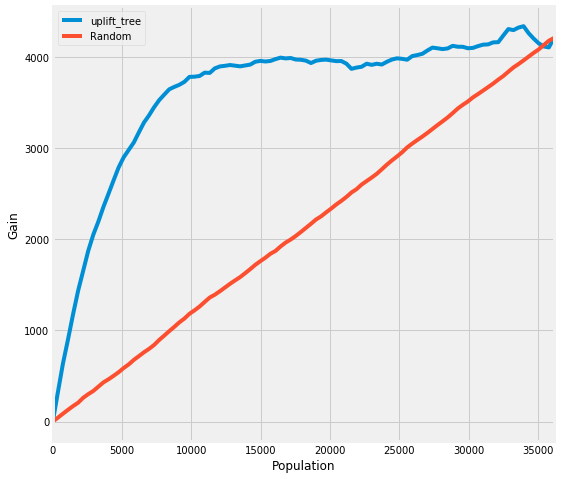

In [35]:
# using top 20 features
s_rf_res_t20, _ = model_train(slearner_rf, df_train, df_test, top_20_features)

In this notebook, we demonstrated how our Filter method functions are able to select important features and enhance the AUUC performance (while the results might vary among different datasets, models and hyper-parameters).